# Task 1 Skeleton Code

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import math
import re
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import scipy.io as sio
plt.rcParams['figure.figsize'] = 10,10

import sklearn.datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Original Data

In [37]:
my_iris_data = sklearn.datasets.load_iris()
print ("my_iris_data.data.shape:",my_iris_data.data.shape)
print ("labels:",my_iris_data.target)

my_iris_data.data.shape: (150, 4)
labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [38]:
X_train = np.concatenate((my_iris_data.data[10:50,:],my_iris_data.data[60:100,:], my_iris_data.data[110:150,:]))
X_train = np.concatenate((np.ones((X_train.shape[0],1)),X_train),axis=1) # Append bias term 1
y_train = np.concatenate((my_iris_data.target[10:50],my_iris_data.target[60:100], my_iris_data.target[110:150]))
print ("X_train.shape:", X_train.shape)
print ("y_train.shape:", y_train.shape)

X_test = np.concatenate((my_iris_data.data[40:50,:],my_iris_data.data[90:100,:], my_iris_data.data[140:150,:]))
X_test = np.concatenate((np.ones((X_test.shape[0],1)),X_test),axis=1) # Append bias term 1
y_test = np.concatenate((my_iris_data.target[40:50],my_iris_data.target[90:100], my_iris_data.target[140:150]))
print ("X_test.shape:", X_test.shape)
print ("y_test.shape:", y_test.shape)
# print(X_train)
# print(y_train)
# print(X_train[0].shape)
# print((X_train.shape[1],1))
# print(y_train[0])

X_train.shape: (120, 5)
y_train.shape: (120,)
X_test.shape: (30, 5)
y_test.shape: (30,)


## Preprocess the labels to get 3 datasets

In [39]:
y_train1 = np.copy(y_train); y_test1 = np.copy(y_test)
y_train2 = np.copy(y_train); y_test2 = np.copy(y_test)
y_train3 = np.copy(y_train); y_test3 = np.copy(y_test)

y_train1[y_train == 1] = -1
y_train1[y_train == 2] = -1
y_train1[y_train == 0] = 1
y_test1[y_test == 1] = -1
y_test1[y_test == 2] = -1
y_test1[y_test == 0] = 1

y_train2[y_train == 1] = 1
y_train2[y_train == 2] = -1
y_train2[y_train == 0] = -1
y_test2[y_test == 1] = 1
y_test2[y_test == 2] = -1
y_test2[y_test == 0] = -1

y_train3[y_train == 1] = -1
y_train3[y_train == 2] = 1
y_train3[y_train == 0] = -1
y_test3[y_test == 1] = -1
y_test3[y_test == 2] = 1
y_test3[y_test == 0] = -1

## Task 1: OvA SVM on iris
We use gradient descent to train 3 SVMs

Original target function: 

$ L(\textbf{w}) = \frac{1}{2} \left \| \textbf{w} \right \|^2 + C \sum_i max(0, 1- y_i \times <\textbf{x}_i, \textbf{w}>) $

The gradient w.r.t $\textbf{w}$ of the target function:

$ L'(\textbf{w})=\frac{d L(\textbf{w})}{d \textbf{w}} = \textbf{w} +C \sum_i \left\{\begin{matrix} -y_i  \textbf{x}_i & \text{, if }  y_i \times < \textbf{x}_i, \textbf{w}> \le 1\\ 
0 & \texttt{, otherwise} 
\end{matrix}\right. $

In [40]:
#C=10 # the lambda
C = 0.5
learning_rate = 0.0001 # the alpha
n_iter = 20000
iterations = []

In [41]:
def L_prime_w(X, Y, w, C=10):
    gradient = w.copy()  
    for i in range(X.shape[0]):
        if Y[i] * np.dot(X[i], w) <= 1:
            gradient -= C * Y[i] * X[i].reshape(-1, 1)  
    return gradient


In [42]:
def L_w(X, Y, w, C):
    hinge_loss = 0
    for i in range(X.shape[0]):
        hinge_loss += np.maximum(0, 1 - Y[i] * np.dot(X[i], w))
    total_loss = 0.5 * np.linalg.norm(w) ** 2  + C * hinge_loss
    return total_loss


In [43]:
#w = np.random.randn(X_train.shape[1], 1)
def train_svm(X_train, Y_train,C):
    w = np.zeros((X_train.shape[1],1))
    
    for i in range(n_iter):
        gradient = L_prime_w(X_train, Y_train, w,C)
        w_new = w - learning_rate*gradient
        iterations.append(i+1)

        # if np.linalg.norm(w_new - w, ord = 1) < 0.001:
        #     print("gradient descent has converged after " + str(i) + " iterations")
        #     break
        # if i % 1000 == 0:
        #     print(i, np.linalg.norm(w_new - w, ord = 1))
        w = w_new
    return w

### (Warning! The next cell takes time to finish the descending)

In [44]:
#get the optimal w for different labeled classes
w1 = np.copy(train_svm(X_train, y_train1,C=0.5))
print ("w1 vector:",  w1.tolist())
w2 = np.copy(train_svm(X_train, y_train2,C=0.5))
print ("w2 vector:",  w2.tolist())
w3 = np.copy(train_svm(X_train, y_train3,C=0.5))
print ("w3 vector:",  w3.tolist())

w1 vector: [[0.12808821776748938], [0.1870024334783083], [0.5016151664949438], [-0.860564521887039], [-0.48826735025751006]]
w2 vector: [[0.6797992867157607], [0.4292675598135625], [-1.247112832485041], [0.32080247561236963], [-1.086124924252518]]
w3 vector: [[-0.8901972460406317], [-1.0589454744546685], [-0.9868118332280559], [1.5488776885911424], [1.7294248186717587]]


In [45]:
w= np.concatenate((w1,w2,w3),axis=1)
print ("w.shape:", w.shape)

w.shape: (5, 3)


In [46]:
def eva_accuracy(X_train, y_train, w):
    prediction = 2 * (np.dot(X_train, w) >= 0) - 1
    accuracy = np.sum(prediction == y_train.reshape(-1, 1))*1.0/X_train.shape[0]
    return accuracy
#print(prediction.shape, Y_test.shape)
accuracy1 = eva_accuracy(X_train, y_train1, w1)
print ("training accuracy1: " + str(accuracy1))
accuracy2 = eva_accuracy(X_train, y_train2, w2)
print ("training accuracy2: " + str(accuracy2))
accuracy3 = eva_accuracy(X_train, y_train3, w3)
print ("training accuracy3: " + str(accuracy3))

training accuracy1: 1.0
training accuracy2: 0.7083333333333334
training accuracy3: 0.975


### Results on training set

In [47]:
#We are getting the optimal w and b during the training process;
#For now we are trying to get the optimal y to correctly label?
prediction1 = np.dot(X_train, w1)
prediction2 = np.dot(X_train, w2)
prediction3 = np.dot(X_train, w3)
preds = np.concatenate((prediction1, prediction2, prediction3),axis=1)
#preds have 3 columns, first column assciated with w1, second with w2, third with w3, they are the predicited values, we want wx+b to be greater than 1, the greater the better so that
#it won't fall into the margin
#the argmaax function iterates over each row (axis 1), and returns the index of the maximum value in each row
#the index is indeed the predicated label (0,1,2) we obtained from our training model.
pred = np.argmax(preds, axis=1)
total_accuracy = np.sum(pred == y_train)*1.0/X_train.shape[0]
print ("Total training accuracy:", total_accuracy*100, "%.")

Total training accuracy: 94.16666666666667 %.


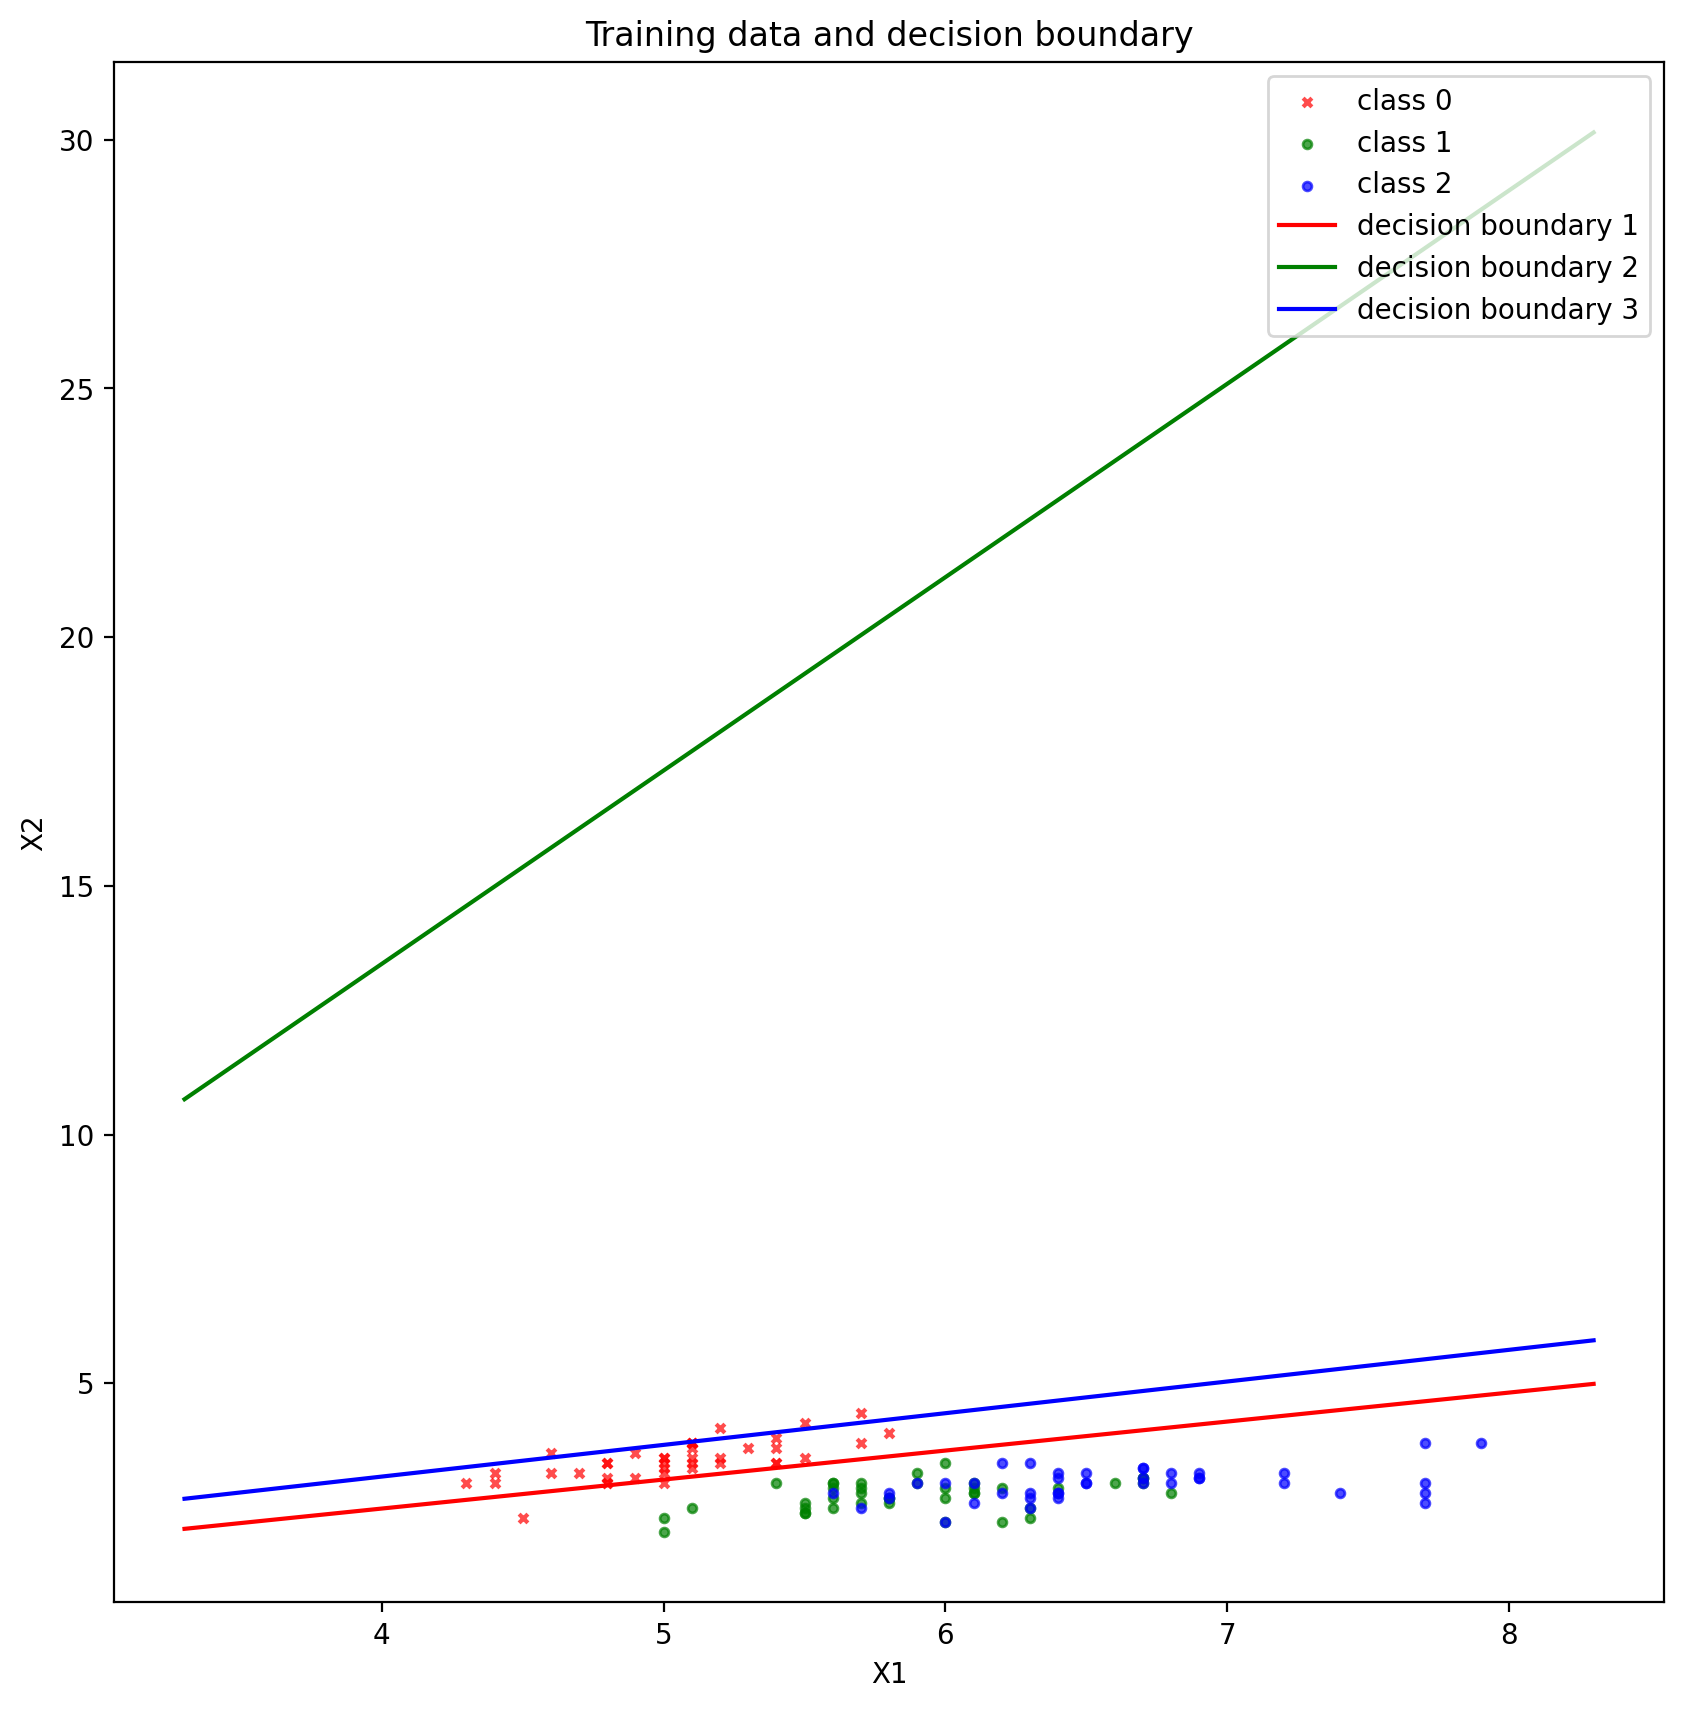

In [48]:
x1 = 1; x2 = 2
x = np.arange(np.min(X_train[:,1])-1,np.max(X_train[:,x1])+1,1.0)
y1 = (-w[0][0]-w[2][0]*x)/w[3][0]
y2 = (-w[0][1]-w[2][1]*x)/w[3][1]
y3 = (-w[0][2]-w[2][2]*x)/w[3][2]

plt.scatter(X_train[y_train==0, x1], X_train[y_train==0, x2], marker='x', color='r', alpha=0.7, s=10, label='class 0')
plt.scatter(X_train[y_train==1, x1], X_train[y_train==1, x2], marker='o', color='g', alpha=0.7, s=10, label='class 1')
plt.scatter(X_train[y_train==2, x1], X_train[y_train==2, x2], marker='o', color='b', alpha=0.7, s=10, label='class 2')

plt.xlabel('X1')
plt.ylabel('X2')
plt.plot(x,y1, color='r', label='decision boundary 1')
plt.plot(x,y2, color='g', label='decision boundary 2')
plt.plot(x,y3, color='b', label='decision boundary 3')
plt.title('Training data and decision boundary')

plt.legend(loc='upper right', fontsize=10)

### Results on test set

In [49]:
prediction1 = np.dot(X_test, w1)
prediction2 = np.dot(X_test, w2)
prediction3 = np.dot(X_test, w3)
preds = np.concatenate((prediction1, prediction2, prediction3),axis=1)
pred = np.argmax(preds, axis=1)

total_accuracy = np.sum(pred == y_test)*1.0/X_test.shape[0]
print ("Total test accuracy:", total_accuracy*100, "%.")

Total test accuracy: 100.0 %.


running for 0.5
The optimal w value for 0.5 is [[ 0.12808822  0.67979929 -0.89019725]
 [ 0.18700243  0.42926756 -1.05894547]
 [ 0.50161517 -1.24711283 -0.98681183]
 [-0.86056452  0.32080248  1.54887769]
 [-0.48826735 -1.08612492  1.72942482]]
Total training accuracy: 94.16666666666667 %.
Total test accuracy: 100.0 %.
running for 2.0
The optimal w value for 2.0 is [[ 0.16164012  2.21351579 -2.05987519]
 [ 0.30395953  0.34098612 -1.12019659]
 [ 0.44202364 -1.82561834 -1.20483829]
 [-1.05539079  0.97554793  1.76733841]
 [-0.59832323 -2.47975797  2.39624666]]
Total training accuracy: 91.66666666666666 %.
Total test accuracy: 100.0 %.
running for 5.0
The optimal w value for 5.0 is [[ 0.16151848  3.4368349  -3.48209717]
 [ 0.30236144  0.10665453 -1.0944214 ]
 [ 0.44803084 -1.93285783 -1.87889936]
 [-1.05404744  1.25357021  2.15141504]
 [-0.60240084 -2.88237856  3.22562476]]
Total training accuracy: 94.16666666666667 %.
Total test accuracy: 100.0 %.
running for 10.0
The optimal w value for 10

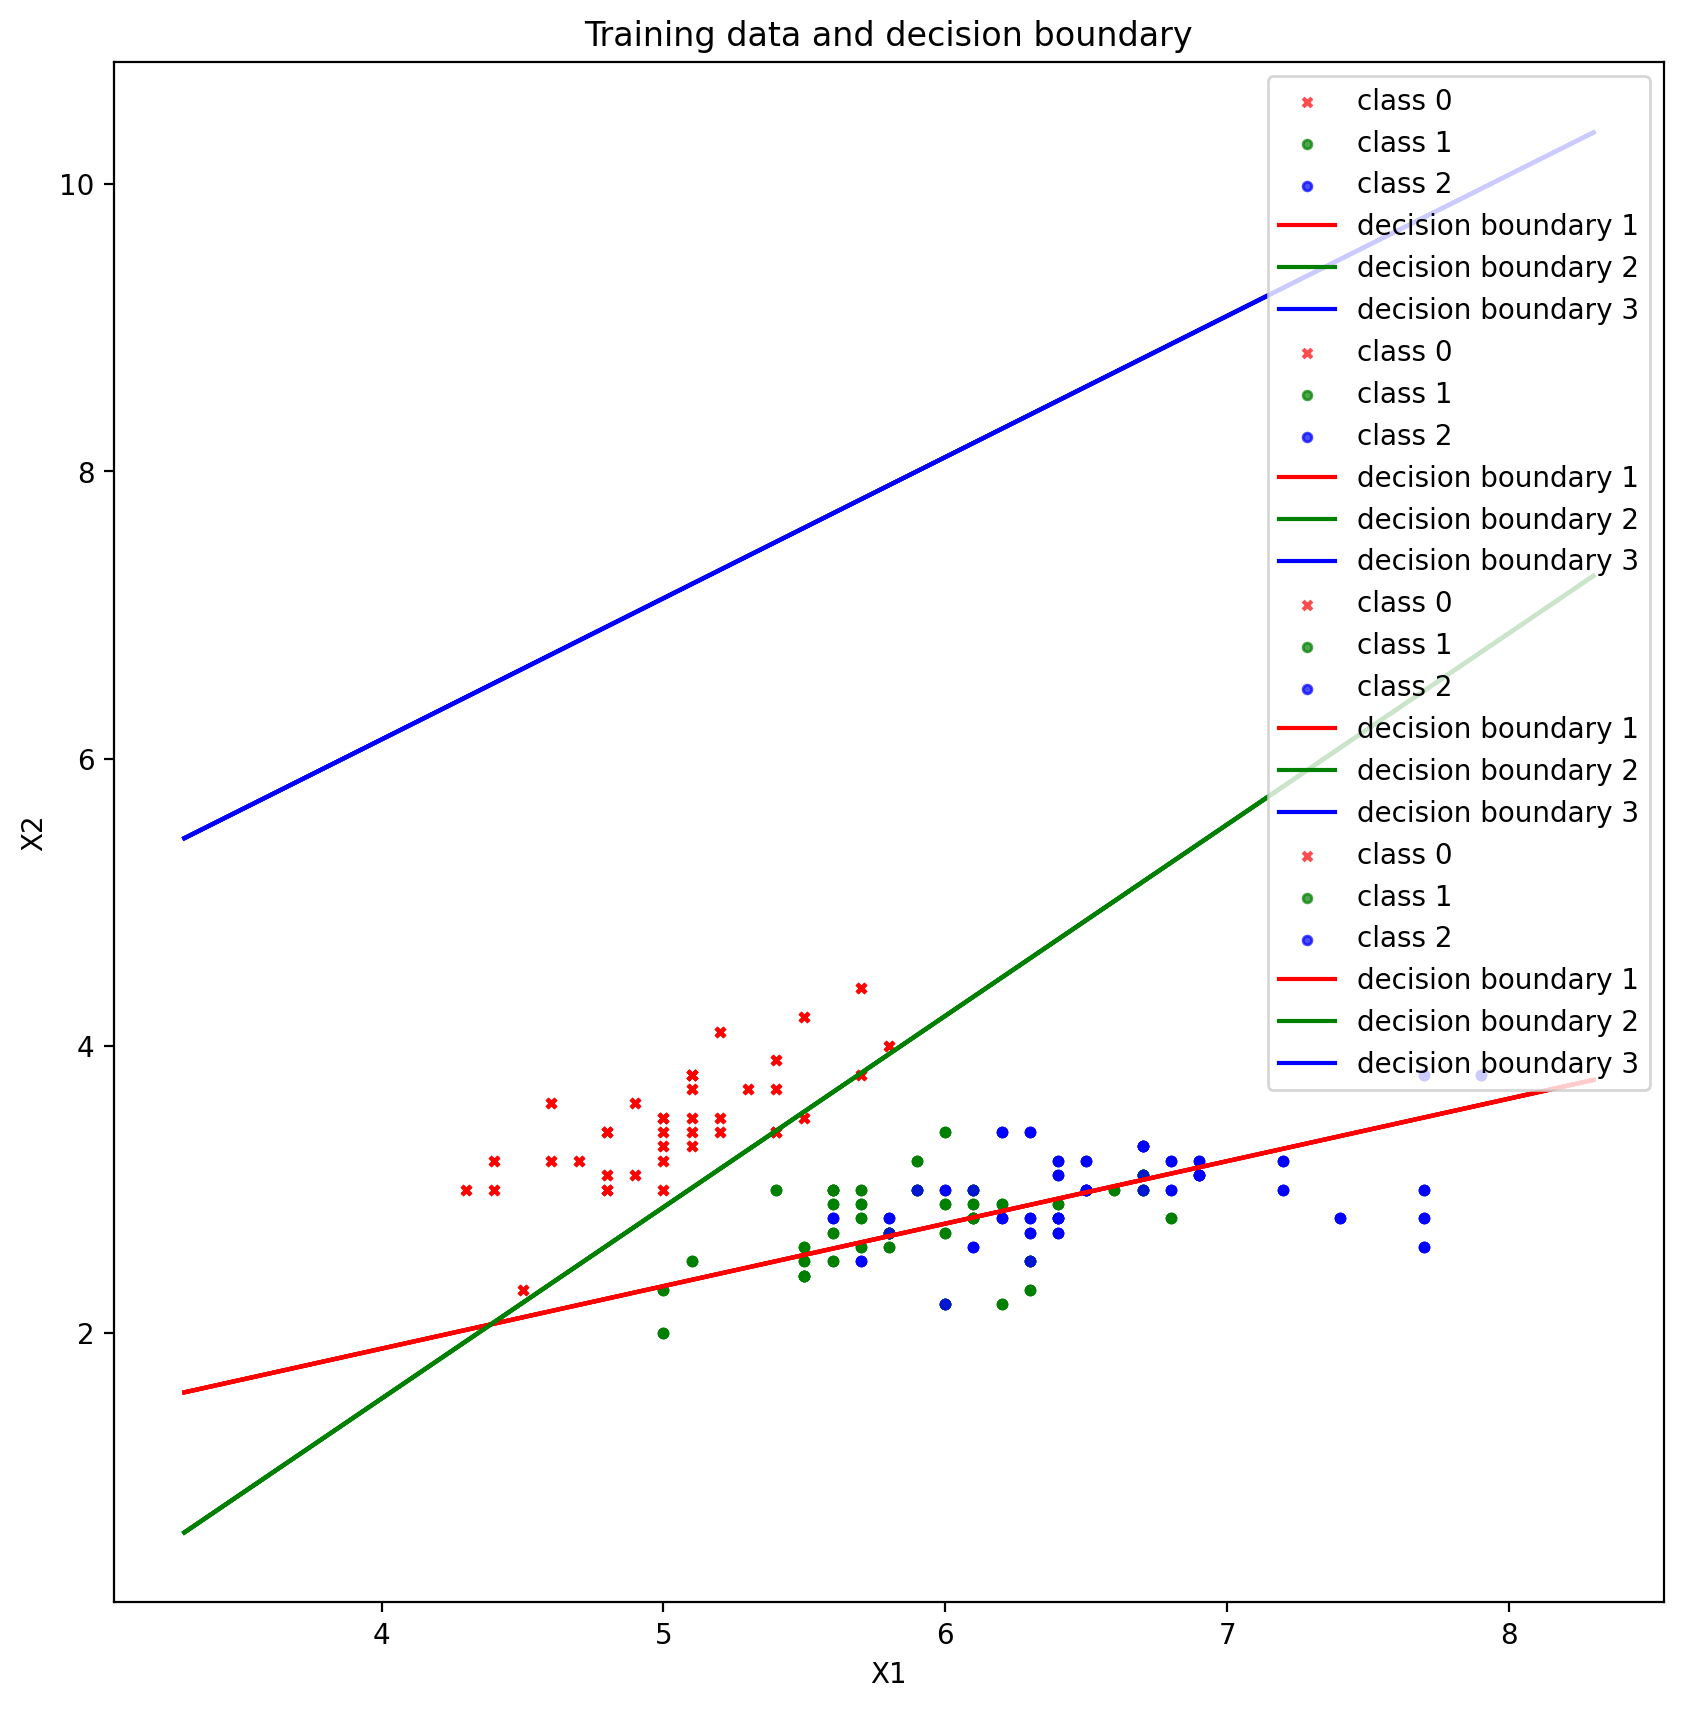

In [54]:
C_values = [0.5, 2.0, 5.0, 10.0]

for C in C_values:
    print('running for {}'.format(C))
    w1 = np.copy(train_svm(X_train, y_train1,C))
    #print ("w1 vector:",  w1.tolist())
    w2 = np.copy(train_svm(X_train, y_train2,C))
    #print ("w2 vector:",  w2.tolist())
    w3 = np.copy(train_svm(X_train, y_train3,C))
    #print ("w3 vector:",  w3.tolist())
    w= np.concatenate((w1,w2,w3),axis=1)  
    print('The optimal w value for {} is {}'.format(C,w))
    # L_val = L_w(X_train, y_train, w,C)
    prediction1 = np.dot(X_train, w1)
    prediction2 = np.dot(X_train, w2)
    prediction3 = np.dot(X_train, w3)
    preds = np.concatenate((prediction1, prediction2, prediction3),axis=1)
    pred = np.argmax(preds, axis=1)
    total_accuracy = np.sum(pred == y_train)*1.0/X_train.shape[0]
    print ("Total training accuracy:", total_accuracy*100, "%.")
    prediction1 = np.dot(X_test, w1)
    prediction2 = np.dot(X_test, w2)
    prediction3 = np.dot(X_test, w3)
    preds = np.concatenate((prediction1, prediction2, prediction3),axis=1)
    pred = np.argmax(preds, axis=1)
    total_accuracy = np.sum(pred == y_test)*1.0/X_test.shape[0]
    print ("Total test accuracy:", total_accuracy*100, "%.")
    plt.scatter(X_train[y_train==0, x1], X_train[y_train==0, x2], marker='x', color='r', alpha=0.7, s=10, label='class 0')
    plt.scatter(X_train[y_train==1, x1], X_train[y_train==1, x2], marker='o', color='g', alpha=0.7, s=10, label='class 1')
    plt.scatter(X_train[y_train==2, x1], X_train[y_train==2, x2], marker='o', color='b', alpha=0.7, s=10, label='class 2')

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.plot(x,y1, color='r', label='decision boundary 1')
    plt.plot(x,y2, color='g', label='decision boundary 2')
    plt.plot(x,y3, color='b', label='decision boundary 3')
    plt.title('Training data and decision boundary')

    plt.legend(loc='upper right', fontsize=10)



The optimal w value is [[ 0.15983746  6.39176826 -4.40728501]
 [ 0.2970873  -0.31933683 -0.92796169]
 [ 0.45801751 -2.25023377 -1.96619639]
 [-1.0526293   1.6890044   2.00050391]
 [-0.60438444 -3.30471002  3.70373197]]


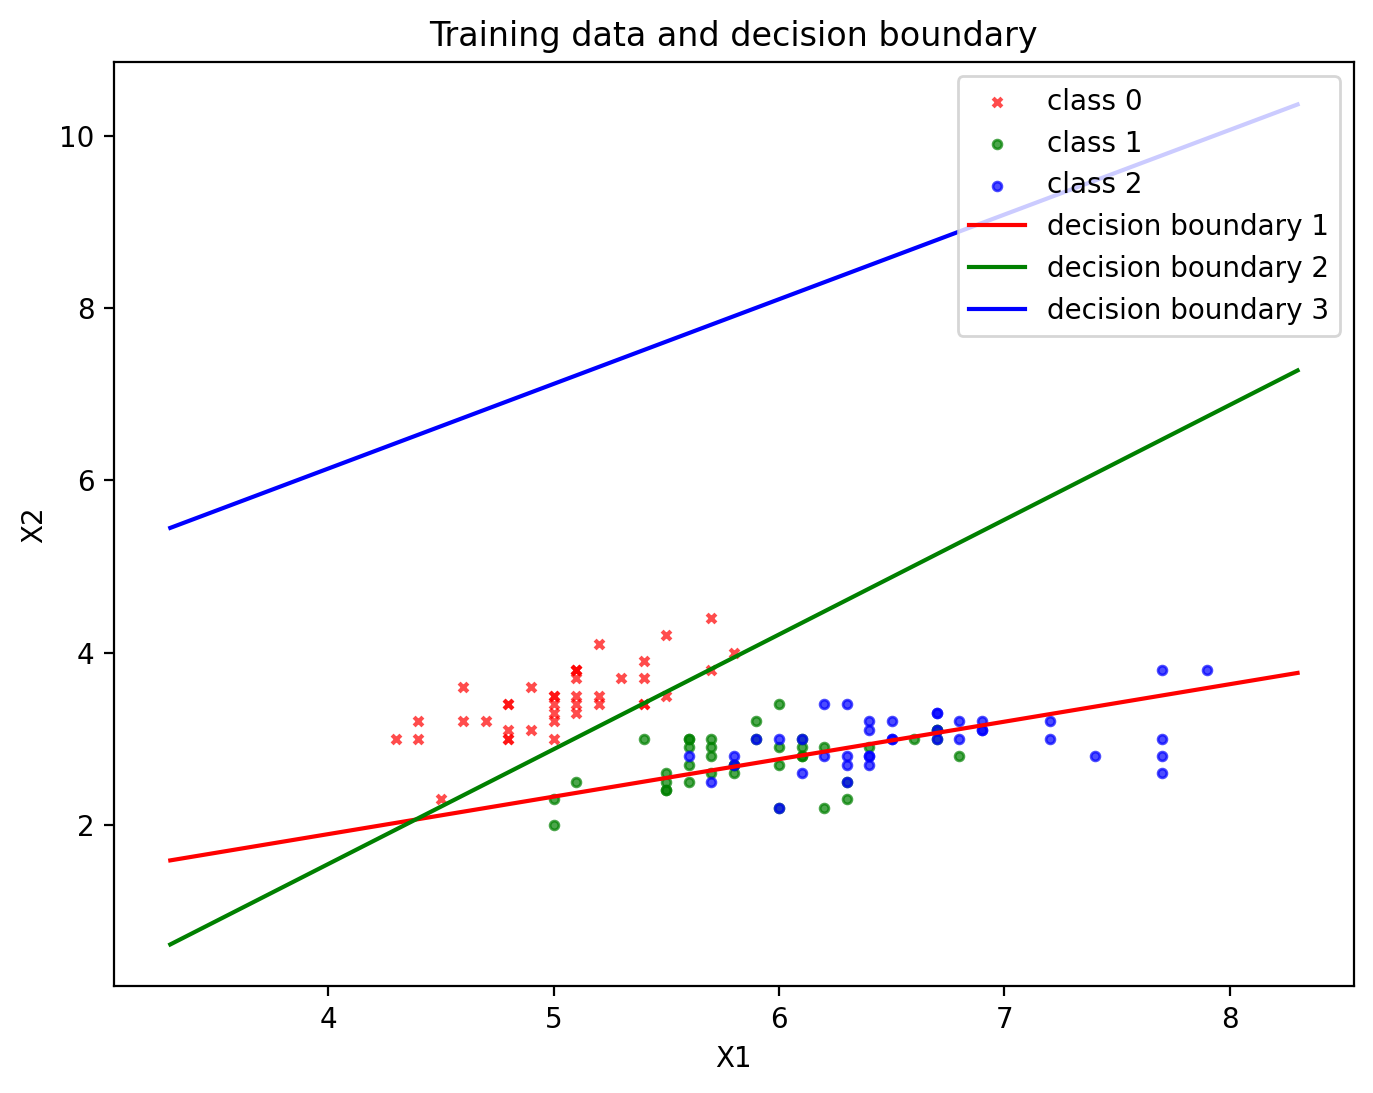

In [53]:
w1 = np.copy(train_svm(X_train, y_train1,10.0))
#print ("w1 vector:",  w1.tolist())
w2 = np.copy(train_svm(X_train, y_train2,10.0))
#print ("w2 vector:",  w2.tolist())
w3 = np.copy(train_svm(X_train, y_train3,10.0))
#print ("w3 vector:",  w3.tolist())
w= np.concatenate((w1,w2,w3),axis=1)  
print('The optimal w value is {}'.format(w))
plt.figure(figsize=(8, 6)) 
x1 = 1; x2 = 2
x = np.arange(np.min(X_train[:,1])-1,np.max(X_train[:,x1])+1,1.0)
y1 = (-w[0][0]-w[2][0]*x)/w[3][0]
y2 = (-w[0][1]-w[2][1]*x)/w[3][1]
y3 = (-w[0][2]-w[2][2]*x)/w[3][2]

plt.scatter(X_train[y_train==0, x1], X_train[y_train==0, x2], marker='x', color='r', alpha=0.7, s=10, label='class 0')
plt.scatter(X_train[y_train==1, x1], X_train[y_train==1, x2], marker='o', color='g', alpha=0.7, s=10, label='class 1')
plt.scatter(X_train[y_train==2, x1], X_train[y_train==2, x2], marker='o', color='b', alpha=0.7, s=10, label='class 2')

plt.xlabel('X1')
plt.ylabel('X2')
plt.plot(x,y1, color='r', label='decision boundary 1')
plt.plot(x,y2, color='g', label='decision boundary 2')
plt.plot(x,y3, color='b', label='decision boundary 3')
plt.title('Training data and decision boundary')

plt.legend(loc='upper right', fontsize=10)